**Goal of the project**

With the rapid development of sharing economy, massive sharing systems such as Uber, Airbnb, and bikeshare have percolated into people's daily life. All these businesses share one commonality, for which consumer demand is upon request. Namely, suppliers need to immediately, if not instantaneously, deploy goods and services as soon as demand is generated. On the one hand, the success of sharing economy lies at such on-demand features; on the other hand, this requires supplies to predict consumers demand on various occasions as accurately as possible in the first place, thereby diverting goods and services to consumers as efficiently and timely as possible.

In this project, we aim to use machine learning techniques to predict consumer demand for bike sharing.

**Load the packages**

In [30]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Load the data**

For this project, the dataset of [bike-sharing demand in Seoul](https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-sharing-demand-prediction) was used. The dataset includes Seoul Bike sharing system data and weather information corresponding to each hour of the year.

In [31]:
df = pd.read_csv('../input/seoul-bike-sharing-demand-prediction/SeoulBikeData.csv', encoding = 'cp1252')

In [32]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [33]:
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [34]:
# Examine the data
df.head()

,date,rented bike count,hour,temperature(°c),humidity(%),wind speed (m/s),visibility (10m),dew point temperature(°c),solar radiation (mj/m2),rainfall(mm),snowfall (cm),seasons,holiday,functioning day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,winter,no holiday,yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,winter,no holiday,yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,winter,no holiday,yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,winter,no holiday,yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,winter,no holiday,yes


In [35]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented bike count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind speed (m/s)           8760 non-null   float64
 6   visibility (10m)           8760 non-null   int64  
 7   dew point temperature(°c)  8760 non-null   float64
 8   solar radiation (mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall (cm)              8760 non-null   float64
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning day            8760 non-null   objec

**Changing a date string to a datetime**

We’ll be using the to_datetime( ) function to convert the date to datetime object.

In [36]:
df['date'] = pd.to_datetime(df['date'])

**Engineer datetime features**

In [37]:
df['day_of_week'] = df['date'].dt.strftime('%w').astype(int)

In [38]:
df['day_of_year'] = df['date'].dt.strftime('%j').astype(int)

In [39]:
df['weekend'] = ((pd.DatetimeIndex(df['date']).dayofweek) // 5 == 1).astype(int)

In [40]:
df['working_day'] = np.where((df['weekend'] == 1) | (df['holiday'] == 'holiday'), 0, 1)

In [41]:
df['week'] = df['date'].dt.strftime('%W').astype(int)

In [42]:
df['month'] = df['date'].dt.strftime('%m').astype(int)

In [43]:
df['year_month'] = df['date'].dt.strftime('%Y%m').astype(int)

In [44]:
# Drop the 'date' column
df = df.drop('date', axis = 1)

**Check for missing values**

In [45]:
df.isnull().sum()

rented bike count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind speed (m/s)             0
visibility (10m)             0
dew point temperature(°c)    0
solar radiation (mj/m2)      0
rainfall(mm)                 0
snowfall (cm)                0
seasons                      0
holiday                      0
functioning day              0
day_of_week                  0
day_of_year                  0
weekend                      0
working_day                  0
week                         0
month                        0
year_month                   0
dtype: int64

**Split the training and test data**

Next we will split our dataset into the X feature set and the y target data, and we will use the train_test_split( ) function to create our test and training datasets.

In [46]:
X = df.drop(['rented bike count'], axis = 1) 

In [47]:
y = df['rented bike count']

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Create a model pipeline**

In [50]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [51]:
def get_pipeline(X, model):

    numeric_columns = list(X.select_dtypes(exclude = ['object']).columns.values.tolist())    
    categorical_columns = list(X.select_dtypes(include = ['object']).columns.values.tolist())
    categorical_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    
    preprocessor = ColumnTransformer(transformers = [('numeric', 'passthrough', numeric_columns), 
                                                     ('categorical', categorical_transformer, categorical_columns)], remainder = 'passthrough')

    bundled_pipeline = imbpipeline(steps = [('preprocessor', preprocessor),
                                            ('scaler', RobustScaler()),
                                            ('model', model)])
    
    return bundled_pipeline

**Apply model selection**

To undertake the model selection step, we first need to create a dictionary containing the name of each model we want to test, and the name of the model class, i.e. XGBRegressor( ).

Next we will create a Pandas dataframe into which we will store the data. Then we will loop over each of the models, fit it using the X_train and y_train data, then generate predictions from X_test and calculate the mean R-squared from 5 rounds of cross-validation. That will give us the R-squared for the X_test data, plus the average R-squared for the training data set.

In [52]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

In [53]:
def select_model(X, y, pipeline = None):

  regressors = {}
  regressors.update({'XGBRegressor': XGBRegressor(objective = 'reg:squarederror', random_state = 42)})
  regressors.update({'LGBMRegressor': LGBMRegressor(random_state = 42)})
  regressors.update({'DecisionTreeRegressor': DecisionTreeRegressor(random_state = 42)})
  regressors.update({'BaggingRegressor': BaggingRegressor(random_state = 42)})
  regressors.update({'GradientBoostingRegressor': GradientBoostingRegressor(random_state = 42)})
  regressors.update({'AdaBoostRegressor': AdaBoostRegressor(random_state = 42)})
  regressors.update({'HistGradientBoostingRegressor': HistGradientBoostingRegressor(random_state = 42)})
  
  models = []
  models.append(('HistGradientBoostingRegressor', HistGradientBoostingRegressor(random_state = 42)))
  models.append(('LGBMRegressor', LGBMRegressor(random_state = 42)))
  regressors.update({'VotingRegressor (HistGradientBoostingRegressor, LGBMRegressor)': VotingRegressor(models)})
    
  df_models = pd.DataFrame(columns = ['model', 'run_time', 'r2_score_cv', 'r2_score'])

  for key in regressors:

      print('*', key)

      start_time = time.time()
      
      pipeline = get_pipeline(X_train, regressors[key])

      cv = cross_val_score(pipeline, X, y, cv = 5, scoring = 'r2', n_jobs = -1)

      pipeline.fit(X_train, y_train)
      y_pred = pipeline.predict(X_test)

      row = {'model': key,
             'run_time': format(round((time.time() - start_time) / 60, 2)),
             'r2_score_cv': cv.mean(),
             'r2_score': r2_score(y_test, y_pred)}

      df_models = df_models.append(row, ignore_index = True)

  df_models = df_models.sort_values(by = 'r2_score', ascending = False)
      
  return df_models

Running the select_model( ) function on our training data takes a minute or so. The best independent models were HistGradientBoostingRegressor and LGBMRegressor. However, it was the VotingRegressor which includes a combination of these models that generated the top result overall. The extra performance is minimal, and we may be able to achieve better results by tuning an additional model, but it’s not bad.

In [54]:
models = select_model(X_train, y_train)

* XGBRegressor
* LGBMRegressor
* DecisionTreeRegressor
* BaggingRegressor
* GradientBoostingRegressor
* AdaBoostRegressor
* HistGradientBoostingRegressor
* VotingRegressor (HistGradientBoostingRegressor, LGBMRegressor)


In [55]:
models.head(10)

,model,run_time,r2_score_cv,r2_score
7,VotingRegressor (HistGradientBoostingRegressor...,0.05,0.919759,0.916133
6,HistGradientBoostingRegressor,0.04,0.919143,0.916113
1,LGBMRegressor,0.03,0.918011,0.913648
0,XGBRegressor,0.13,0.915650,0.911824
3,BaggingRegressor,0.03,0.889576,0.890559
4,GradientBoostingRegressor,0.08,0.849887,0.832113
2,DecisionTreeRegressor,0.01,0.792618,0.773236
5,AdaBoostRegressor,0.04,0.553029,0.569889


**Assess the top performing model**

Finally, we can take our best model - the VotingRegressor comprising HistGradientBoostingRegressor and LGBMRegressor - and fit the data on this. To do this step, we’ll first define our stacked model, then we’ll pass its configuration to get_pipeline( ) with our training data. Then, we’ll fit( ) the training data and use predict( ) to return our predictions from the newly trained model.

In [56]:
stacked_models = []
stacked_models.append(('HistGradientBoostingRegressor', HistGradientBoostingRegressor(random_state = 42)))
stacked_models.append(('LGBMRegressor', LGBMRegressor(random_state = 42)))
stacked_model = VotingRegressor(stacked_models)

In [57]:
bundled_pipeline = get_pipeline(X_train, stacked_model)
bundled_pipeline.fit(X_train, y_train)
y_pred = bundled_pipeline.predict(X_test)

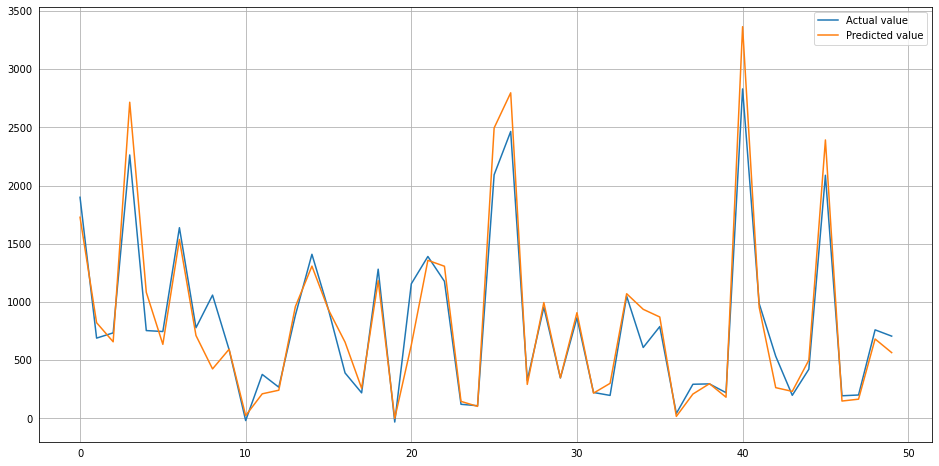

In [58]:
test = pd.DataFrame({'Predicted value': y_pred, 'Actual value': y_test})
fig = plt.figure(figsize = (16, 8))
test = test.reset_index()
test = test.drop(['index'], axis = 1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])
plt.tick_params(left = False, bottom = False)
plt.grid()